Initialise the program

In [66]:
BingMaps_SubKey = 'AmBoRv3gxkkwONkQCMXteGMO2QtRevzFGx7HSsXEPzVDqXQlUGulxlwW8RpQOKbS'
BingMaps_format = 'JPEG' #Options for PNG or GIF
BingMaps_Size = '1200,1200' # x,y or horizontal vs vertical
BingMaps_Style = 'Aerial' #Options include Aerial; AerialWithLabels; Road; see https://msdn.microsoft.com/en-us/library/ff701716.aspx
MaxCircle_Size = 30
MinCircle_Size = 5
Output_Map = "Tesco-Ipswich-Locations.jpg"
Read_CSV = "Tesco-Ipswich4"
Output_CSV = Read_CSV + "-out"

Read_CSV += ".csv"
Output_CSV += ".csv"
Aug_Map = "Aug-"+ Output_Map

import requests
import sys
import urllib.request
import json
import pandas as pd
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches

# Icon Codes - 67 is smallest. Colours - (g)reen; (r)ed; (b)lue; (w)hite; (y)ellow

Icon_DF = pd.DataFrame(data={'Company':["Tesco", "One Stop", "Busyg"], 'Large':[67,67,67], 'Medium':[67,67,67], 'Small':[67,67,67], 'Colour':['b','r','w']})


Read CSV file from local drive and import into data file.

In [67]:
assert Read_CSV
try:
    source_data = pd.read_csv(Read_CSV, sep=",", keep_default_na=False)
except NameError:
    sys.exit("Source file Not Found.")
except Exception:
    sys.exit("Error in reading file")
#print(source_data)
#print(source_data['City'])

Validate the DataFrame has the correct columns.

In [68]:
def DFValidate():
    if not 'Icon' in source_data.columns:
        source_data["Icon"]=""
        print("NOTE - Icon field not found - created")
    if not 'Postcode' in source_data.columns and not 'City' in source_data.columns:
        print("ERROR - No Postcode or City fields found. - EXIT")
        sys.exit()
    
    if not 'Postcode' in source_data.columns:
        source_data["Postcode"]=""
        print("NOTE - Postcode field not found - created")
    if not 'Longitude' in source_data.columns:
        source_data["Longitude"]=0.0
        print("NOTE - Longitude field not found - created")
    if not 'Latitude' in source_data.columns:
        source_data["Latitude"]=0.0
        print("NOTE - Longitude field not found - created")
    if not 'Company' in source_data.columns:
        Company = Icon_DF["Company"][0]
        source_data["Company"] = Company
        print("NOTE - Company field not found - created and populated with:", Company)

Define a function to validate Latitude / Longitude coordinates

In [69]:
def CoordTest(num_in):
    if num_in:
        if not isinstance(num_in, float):
            num = float(num_in)
            if num > -180 and num < 180:
                num_bool = True
            else:
                num_bool = False
        else:
            num = num_in
            if num > -180 and num < 180:
                num_bool = True
            else:
                num_bool = False
    else:
        num_bool = False
    return(num_bool)

Define a function to lookup using BING Maps API

http://dev.virtualearth.net/REST/v1/Locations/1%20Microsoft%20Way%20Redmond%20WA%2098052?o=xml&key=BingMapsKey

http://dev.virtualearth.net/REST/v1/Locations?countryRegion=countryRegion&adminDistrict=adminDistrict&locality=locality&postalCode=postalCode&addressLine=addressLine&userLocation=userLocation&userIp=userIp&usermapView=usermapView&includeNeighborhood=includeNeighborhood&maxResults=maxResults&key=BingMapsKey


Return the co-ordinates of the location

In [70]:
def BingLookup(Location, row):

    #Next line prepares a lookup string for inclusion in a URL - e.g. replaces spaces with %20
    encodedPostCode = urllib.parse.quote(Location, safe='')

    httprequest = 'http://dev.virtualearth.net/REST/v1/Locations/' + encodedPostCode + '?&key=' + BingMaps_SubKey
        
    request = urllib.request.Request(httprequest)
    response = urllib.request.urlopen(request)
    data = json.loads(response.read())
    
#    print(json.dumps(data, indent=8)) # used to print out the json response in a readable format to identify the nesting
    coordinates = "0,0"

    if data['resourceSets'][0]['estimatedTotal'] == 0:
        postcode = "Not Found"
        
        new_postcode = pd.DataFrame({'Postcode': [postcode]}, index=[row])
        source_data.update(new_postcode) 
    else:
        coordinates = data['resourceSets'][0]['resources'][0]['point']['coordinates']
                                                                    
#    print(coordinates)
        
    return(coordinates)

Define a function to provide Bing Map imagery of locations with pushpins

https://dev.virtualearth.net/REST/v1/Imagery/Map/imagerySet?pushpin={pushpin_1}&pushpin={pushpin_2}&pushpin={pushpin_n}&mapLayer={mapLayer}&format={format}&mapMetadata={mapMetadata}&key={BingMapsKey}  

Define a function to use the address to lookup the postcode if a postcode doesn't exist

In [71]:
def BingPostcodeLookup(Address, City, row):
    Lookup_Address = Address + " , " + City
    
#    print(Lookup_Address)
    #Next line prepares a lookup string for inclusion in a URL - e.g. replaces spaces with %20
    encodedLookup_Address = urllib.parse.quote(Lookup_Address, safe='')
    
    httprequest = 'http://dev.virtualearth.net/REST/v1/Locations/' + encodedLookup_Address + '?&key=' + BingMaps_SubKey
        
    request = urllib.request.Request(httprequest)
    response = urllib.request.urlopen(request)
    data = json.loads(response.read())
    
#    print(json.dumps(data, indent=8))
    
    if 'postalCode' not in data['resourceSets'][0]['resources'][0]['address']:
        postcode = "Not Found"
    else:
        postcode = data['resourceSets'][0]['resources'][0]['address']['postalCode']
    
#    print(postcode)
    
    new_postcode = pd.DataFrame({'Postcode': [postcode]}, index=[row])
    source_data.update(new_postcode)
    
#    return(coordinates)    


Function to work out and update the pushpin icons

In [72]:
def Pushpin_Icon(Company, Users, Row):
    Count_Icon_DF = 0
    new_Icon = 10
    old_company = ""
    company_color = 0
    for C in Icon_DF["Company"]:
        if C == Company:

# code if pushpin icon needs to be calculated based on size of organisation - if circles the separate code.                 
            if Users <300:
                new_Icon = Icon_DF["Medium"][Count_Icon_DF]
                if Users <100:
                    new_Icon = Icon_DF["Small"][Count_Icon_DF]
            else:
                new_Icon = Icon_DF["Large"][Count_Icon_DF]   
            
            new_Icon = str(new_Icon) + Icon_DF["Colour"][Count_Icon_DF] # code to add colour to the object.
        Count_Icon_DF +=1         
    
    new_Icon_update = pd.DataFrame({'Icon': [new_Icon]}, index=[Row])
    source_data.update(new_Icon_update)

Function to create map and pull through metadata to use for circles to replace pushpins

In [73]:
def BingMapMetaData(pushpin_location):
    Map_Lookup_JSON = 'https://dev.virtualearth.net/REST/v1/Imagery/Map/' + BingMaps_Style + '?' + pushpin_location + "mapSize=" + BingMaps_Size + "&format=" + BingMaps_format + "&mapMetadata=1" + "&key=" + BingMaps_SubKey

    request_JSON = urllib.request.Request(Map_Lookup_JSON)
    response_JSON = urllib.request.urlopen(request_JSON)
    data_JSON = json.loads(response_JSON.read())

#    print(json.dumps(data_JSON, indent=8))
    
    row_count = 0
    source_data["Icon_Coord_x"] = ""
    source_data["Icon_Coord_y"] = ""
    Total_rows = len(source_data.index)
    
    Map_Extent = data_JSON["resourceSets"][0]["resources"][0]["bbox"]

    #print(Map_Extent)
    
    Map_Size_x = Map_Extent[2] - Map_Extent[0]
    Map_Size_y = Map_Extent[3] - Map_Extent[1] 
    Map_Size = max(Map_Size_x, Map_Size_y)
    
    Circle_Size = BingMapCircleSize(Map_Size) #returns MaxCircle_Size_Calc and MinCircle_Size_Calc
    
    for l in data_JSON["resourceSets"][0]["resources"][0]["pushpins"]:
        x_cord = l["anchor"]["x"]
        y_cord = l["anchor"]["y"]
        
#        Icon_CoOrd = str(x_cord) + "," + str(y_cord)
        start_row = row_count
        for n in range(start_row, Total_rows): # to only update the record if a corresponding postcode exists
            if source_data['Postcode'][row_count] == "Not Found":
                row_count += 1
            else:
                break
        
        newIcon_CoOrd = pd.DataFrame({'Icon_Coord_x': [x_cord]}, index=[row_count])
        source_data.update(newIcon_CoOrd)
        newIcon_CoOrd = pd.DataFrame({'Icon_Coord_y': [y_cord]}, index=[row_count])
        source_data.update(newIcon_CoOrd)
        
        row_count +=1
    
    return(Circle_Size)

Function to define the metrics for calculating the size of the Circles based on Size of Map; Area covered; range of users / site.

In [74]:
def BingMapCircleSize(Map_Size):
    Largest = max(source_data["Users"])
    MapSize = BingMaps_Size.split(',')
    Total_MapSize = int(MapSize[0]) * int(MapSize[1]) / 360000
    Total_CoordSize = Map_Size / 13
    MaxCircle_Size_Calc = round(Total_MapSize * MaxCircle_Size)
    MinCircle_Size_Calc = round(Total_MapSize * MinCircle_Size)
    
    return(MaxCircle_Size_Calc, MinCircle_Size_Calc, Largest)

Function to produce the map and save locally.

In [75]:
def BingMapImage(pushpin_location, Circle_Size):
    
    Map_Lookup = 'https://dev.virtualearth.net/REST/v1/Imagery/Map/' + BingMaps_Style + '?' + pushpin_location + "mapSize=" + BingMaps_Size + "&format=" + BingMaps_format + "&key=" + BingMaps_SubKey
    #print(Map_Lookup) #used so you can manually open the HTTPS request.
    Map_request = urllib.request.urlretrieve(Map_Lookup, Output_Map)
    
    # following code to make the map appear within the Jupyter Notebook
    image=Image.open(Output_Map)

    fig,ax = plt.subplots(1)

    ax.imshow(image)

#    ax=plt.imshow(image)

    ax.set_aspect('equal')
    row_count = 0
    Icon_DF["Count"] = 1
    for coord in source_data['Reference']:
        if source_data['Icon_Coord_x'][row_count]:
            
            coord_x = source_data['Icon_Coord_x'][row_count]
            coord_y = source_data['Icon_Coord_y'][row_count]
            coord_x = int(coord_x)
            coord_y = int(coord_y)
            
            colour1 = source_data['Icon'][row_count]
            colour = colour1[-1:]

#            print(coord_x, coord_y)
            rad = source_data['Users'][row_count]
            
            a = Circle_Size[0]
            b = Circle_Size[1]
            c = Circle_Size[2]
        
            rad = rad / c
            rad = rad * a
        
            if rad < MaxCircle_Size:
                rad = b
            
            #Code to 
            Company = source_data['Company'][row_count]
            Trans_Count = 1
            Icon_DF_row = 0
            
            for comp in Icon_DF["Company"]:
                if Icon_DF["Company"][Icon_DF_row] == Company:
                    Trans_Count = Icon_DF["Count"][Icon_DF_row]
                    new_Trans_Count = Trans_Count + 1

                    new_Trans_Count = pd.DataFrame({'Count': [new_Trans_Count]}, index=[Icon_DF_row])
                    Icon_DF.update(new_Trans_Count)
                Icon_DF_row += 1
             
            
            #Calculating the transparency of the circle from 0 > 0.5, 1 = 0.5; 2 = 0.45 etc.
            Div10 = (Trans_Count) / 10
            IntDiv10 = int(Div10)
            RemDiv10 = Div10 - IntDiv10
            Transp = 0.50 - RemDiv10 * 0.5
            
            #overlays the Circles
            circ = patches.Circle((coord_x, coord_y), radius = rad, color = colour, alpha = Transp)
            ax.add_patch(circ)
            
            #Overlays the labels
            plt.text(coord_x - rad, coord_y - rad, source_data['Site Name'][row_count], fontsize = 5, color = 'white', va = 'bottom')
        
        row_count += 1
#    circ = patches.Circle((169, 288), radius = 10)
#    ax.add_patch(circ)        
    
    plt.savefig(Aug_Map)
    
    plt.show()

    plt.close()

Define a function to update datafile with the found co-ordinates

In [76]:
def UpdateDF(Location_lat, Location_long):

    new_lat = pd.DataFrame({'Latitude': [Location_lat]}, index=[row_count])
    new_long = pd.DataFrame({'Longitude': [Location_long]}, index=[row_count])
    source_data.update(new_lat)
    source_data.update(new_long)    


Define a function to create new CSV file with updated data

In [77]:
def UpdateCSV():
    source_data.to_csv(Output_CSV, encoding='utf-8', index=False)

Main part of the program to cycle through each row and call BingLookup to pickup co-ordinates based on Postcode or City.

Update CSV with found co-ordinates.

Once all locations have been identified, call BingMapImage to create a map based on the locations.

NOTE - Icon field not found - created
NOTE - Longitude field not found - created
NOTE - Longitude field not found - created


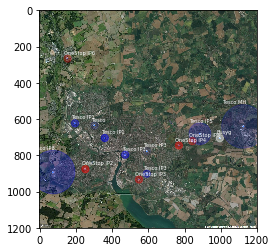

In [78]:
row_count = 0
pushpin_location = ""
DFValidate()
for Location in source_data["Reference"]:
    if source_data["Postcode"][row_count]:
        Location = source_data["Postcode"][row_count]
    else:
        BingPostcodeLookup(source_data["Address"][row_count],source_data["City"][row_count],row_count)
        Location = source_data["Postcode"][row_count]    
    
    LatTest_Return = False
    LongTest_Return = False
    
    if source_data["Latitude"][row_count] and source_data["Longitude"][row_count]:
        Location_lat = source_data["Latitude"][row_count]
        Location_long = source_data["Longitude"][row_count]

        LatTest_Return = CoordTest(Location_lat)
        LongTest_Return = CoordTest(Location_long)

    if not LatTest_Return and not LongTest_Return:
        coordinates = BingLookup(Location, row_count)
        Location_lat = coordinates[0]
        Location_long = coordinates[1]
        UpdateDF(Location_lat, Location_long) #update Dataframe with found location long/lat
    
    #Site reference section
    Site_Ref = source_data["Reference"][row_count]
    if len(Site_Ref) > 3:
        Site_Ref_Short = Site_Ref[:3]
    else:
        Site_Ref_Short = Site_Ref
    
    #Site Icon section
    Site_Icon1 = source_data["Icon"][row_count]
    if not Site_Icon1:
        Users = int(source_data["Users"][row_count])
        Pushpin_Icon(source_data["Company"][row_count], Users, row_count)
        Site_Icon2 = source_data["Icon"][row_count]
        Site_Icon_length = len(Site_Icon1) - 1
        Site_Icon1 = Site_Icon2[:Site_Icon_length]
        Site_Icon1 = int(Site_Icon1)
    
    Site_Icon = int(round(Site_Icon1))
    
    #Create pushpin
    if not source_data["Postcode"][row_count] == "Not Found":        
        pushpin_location +="pushpin=" + str(Location_lat) + "," + str(Location_long) + ";" + str(Site_Icon) + '&' # + Site_Ref_Short + ";"
    
    row_count +=1
    
Circle_Size = BingMapMetaData(pushpin_location) # create Map based on locations using Bing Maps and produce metadata instead of map.
    
BingMapImage(pushpin_location, Circle_Size) #create Map based on locations using Bing Maps

#print(source_data)
UpdateCSV() #create a new file with location latitude / longitude included.

#print("End")